# IoT Challenge - Geolocalization

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [4]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

## Data exploration [Théo]

## Features Engineering [Mathieu]

### "One Hot encoding" of the data

**NB : the different steps of our feature engineering reflexion are presented below, the function that builds our final feature matrix is defined at the end of this section.**


- A first step was to "encode" (transform) the data as the following : as a single 'messid' is represented several times in the data (for each base station that received its signal), we decided to keep only one row for each messid, having columns corresponding to the base stations that received its signal : this is 'one-hot encoding'

Then 

- We decided to go further than simple "one-hot encoding" of base stations and created encoded features using the following : latitude, longitude, rssi, nseq. This means we have now for each base station several columns : its latitude, longitude, rssi and nseq.

In [6]:
## One-hot encoding of base stations
# Train test
train_base_station = np.unique(df_mess_train['bsid'])
# Test set
test_base_station = np.unique(df_mess_test['bsid'])

# Columns of base stations in test set
data_baseid = pd.get_dummies(df_mess_test['bsid'])

# Adding columns of base stations in train set that are not in test set
for base in train_base_station :
    if base not in test_base_station:
        new_col = pd.DataFrame(np.zeros(data_baseid.shape[0]))
        new_col.columns = [base]
        data_baseid = pd.concat([data_baseid, new_col], axis=1)

## Definition of new feature columns
# Create and name base long, lat, rssi and nseq columns
newcolumns_lat = {col : "lat_"+str(col) for col in data_baseid.columns}
newcolumns_lng = {col : "lng_"+str(col) for col in data_baseid.columns}
newcolumns_rssi = {col : "rssi_"+str(col) for col in data_baseid.columns}
newcolumns_nseq = {col : "nseq_"+str(col) for col in data_baseid.columns}

# Renaming columns
data_baseid = data_baseid.astype('int')
data_latid = data_baseid.rename(columns=newcolumns_lat)
data_lngid = data_baseid.rename(columns=newcolumns_lng)
data_rssi = data_baseid.rename(columns=newcolumns_rssi)
data_nseq = data_baseid.rename(columns=newcolumns_nseq)

# Creating new features
for col in data_lngid.columns :
    data_lngid[col] = data_lngid[col]*df_mess_train['bs_lng']

for col in data_latid.columns :
    data_latid[col] = data_latid[col]*df_mess_train['bs_lat']

for col in data_rssi.columns :
    data_rssi[col] = data_rssi[col]*df_mess_train['rssi']

for col in data_nseq.columns :
    data_nseq[col] = data_nseq[col]*df_mess_train['nseq']

## Concatenation in one dataset
new_df = df_mess_train['messid']
new_df = pd.concat([new_df, data_latid, data_lngid, data_rssi,  data_nseq], axis=1)

## Using groupby() to keep only one row per messid and getting final dataFrame of features
df_feat = new_df.groupby('messid').agg('sum')

### New features

#### Centroid of base stations

Then we decided to build a new feature : the centroid (latitude and longitude) of the base stations. 

Indeed, as shown below, as a message is received by one or more base station, there is great probability that it would be located next to the centroid of the base stations that received its signal

In [26]:
# Function that plots the location of base stations and their centroid of a given message
def plot_bases(message_index):
    base_lat = [x for x in df_feat[list(newcolumns_lat.values())].iloc[message_index] if x!=0]
    base_lng = [x for x in df_feat[list(newcolumns_lng.values())].iloc[message_index] if x!=0]
    plt.plot(base_lng, base_lat, 'ob', label='Base stations')
    plt.plot(np.mean(base_lng), np.mean(base_lat), 'or', label="Centroid")
    plt.title('Centroid of Base Stations that received message :\n " {} " '.format(df_feat.index[message_index]))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

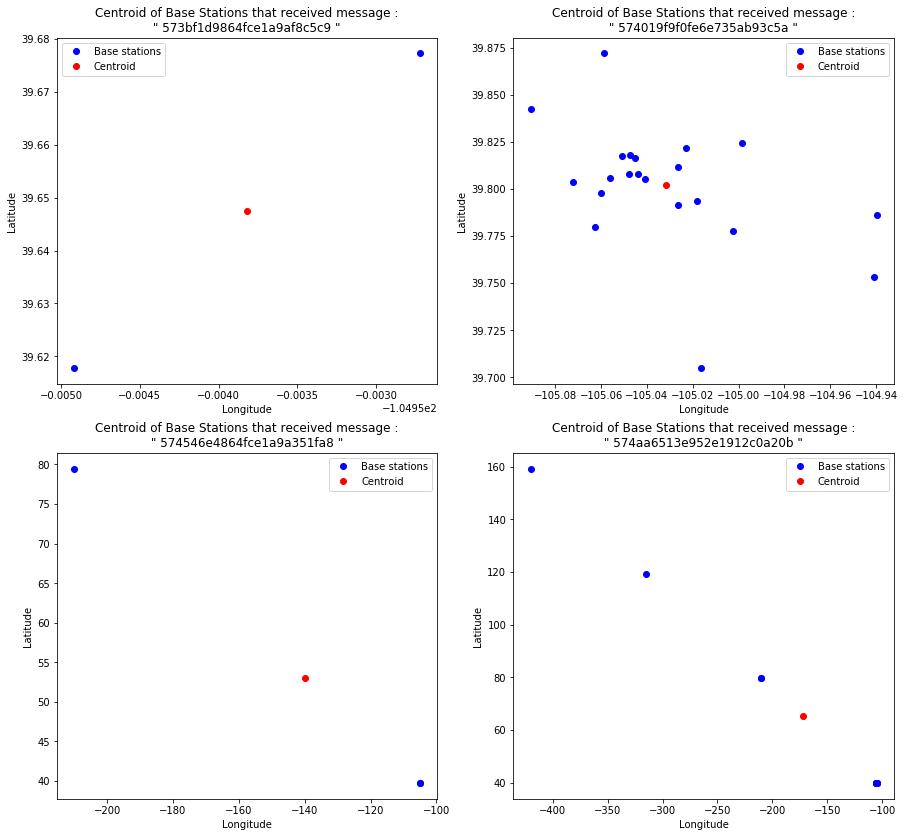

In [27]:
# Plot of the location of base stations and their centroid for a few message
plt.figure(figsize=(15,14))

for i in range(4):
    plt.subplot(221+i)
    plot_bases((i+5)*(10*i))
    plt.legend()

plt.show()

In [9]:
# Definition of centroid of latitude and longitude of base stations for each message
centroid_bs_lat = []
centroid_bs_lng = []

for i in range(df_feat.shape[0]):
    base_lat = [x for x in df_feat[list(newcolumns_lat.values())].iloc[i] if x!=0]
    base_lng = [x for x in df_feat[list(newcolumns_lng.values())].iloc[i] if x!=0]
    centroid_bs_lat.append(np.mean(base_lat))
    centroid_bs_lng.append(np.mean(base_lng))

In [10]:
df_feat["centroid_bs_lat"] = centroid_bs_lat
df_feat["centroid_bs_lng"] = centroid_bs_lng

#### Transformation of rssi

It has been scientifically proved that the power of an electromagnetic wave decreases with the distance it travels.
Actually, a coefficient of attenuation applies to this power and is exponentially related to the distance the wave travels.

The feature rssi being the measure of the power of the signal measured by the base station (rssi = 1/10 * log(Signal Power)),  when plotting the rssi vs. the distance between the position of the device and the base station that received its message, we should see an exponential decreasing trend (at square scale)

The plot below reveals this very trend. It can be noticed that all the points do not "fit" with the trend and are not the same from the device to another : it might be due to :
- obstacles encountered by the message during its travel
- difference of nominal power between devices

In [30]:
 ### Plot @Théo

Despite the potential perturbations in the signal travel, we decided to transform the variable 'rssi' applying the scare root of its exponential. This transformed feature should be representative of the distance the wave travelled (putting aside perturbations)

In [11]:
# Creating new_rssi columns
df_mess_train['new_rssi'] = np.sqrt(np.exp(df_mess_train['rssi'] ))

newcolumns_newrssi = {col : "new_rssi_"+str(col) for col in data_baseid.columns}
data_new_rssi = data_baseid.rename(columns=newcolumns_newrssi)

for col in data_new_rssi.columns :
    data_new_rssi[col] = data_new_rssi[col]*df_mess_train['new_rssi']

# Rebuilding the feature dataframe 
new_df = df_mess_train['messid']
new_df = pd.concat([new_df, data_latid, data_lngid, data_rssi, data_new_rssi, data_nseq], axis=1)

## Grouping by messid
df_feat = new_df.groupby('messid').agg('sum')
df_feat["centroid_bs_lat"] = centroid_bs_lat
df_feat["centroid_bs_lng"] = centroid_bs_lng

#### Rssi-weighted centroid of base station

Having now a feature that should reflect the distance between the base station and where the message received was emitted, we thought it would be worth it trying to build a new feature : the weigthed centroids of base stations using the new feature previously created.

Indeed the closer the message is to a station, the more this station should count in the computation of the centroids of stations.

In [21]:
## Computation of the weighted centroid of base stations
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid']))
bases_num = len(listOfBs)

bases_dict = {}
for i, column in enumerate(listOfBs):
    bases_dict[column] = i

lat_array = np.zeros((df_mess_train.shape[0], bases_num))
lng_array = np.zeros((df_mess_train.shape[0], bases_num))
weights_array = np.zeros((df_mess_train.shape[0], bases_num))

for i in df_mess_train.index:
    # getting bsid for current row
    bsid = df_mess_train.loc[i, 'bsid']
    # getting colum to assign value in bases_array
    column = bases_dict[bsid]
    # assigning weight (sqrt(rssi)) value to cell in bases array
    weight = np.exp(df_mess_train.loc[i, 'rssi'])**(1/2)
    lat_array[i, column] = weight * df_mess_train.loc[i, 'bs_lat']
    lng_array[i, column] = weight * df_mess_train.loc[i, 'bs_lng']
    weights_array[i, column] = weight

# Transforming data arrays into dataframes
lat_df = pd.DataFrame(lat_array)
lng_df = pd.DataFrame(lng_array)
weights_df = pd.DataFrame(weights_array)
# Adding messid column to each data-frame (lat, lng and weights)
lat_df['messid'] = df_mess_train['messid']
lng_df['messid'] = df_mess_train['messid']
weights_df['messid'] = df_mess_train['messid']

#Grouping
lat = lat_df.groupby('messid').sum().sum(axis=1)
lng = lng_df.groupby('messid').sum().sum(axis=1)
weights = weights_df.groupby('messid').sum().sum(axis=1)

# Normalizing by sum of weights
df_weigh = pd.DataFrame([lat, lng], index=['lat','lng'])
df_weigh = (df_weigh/weights).T

The plot below help picture the changes between the new weighted centroid and the previous one 

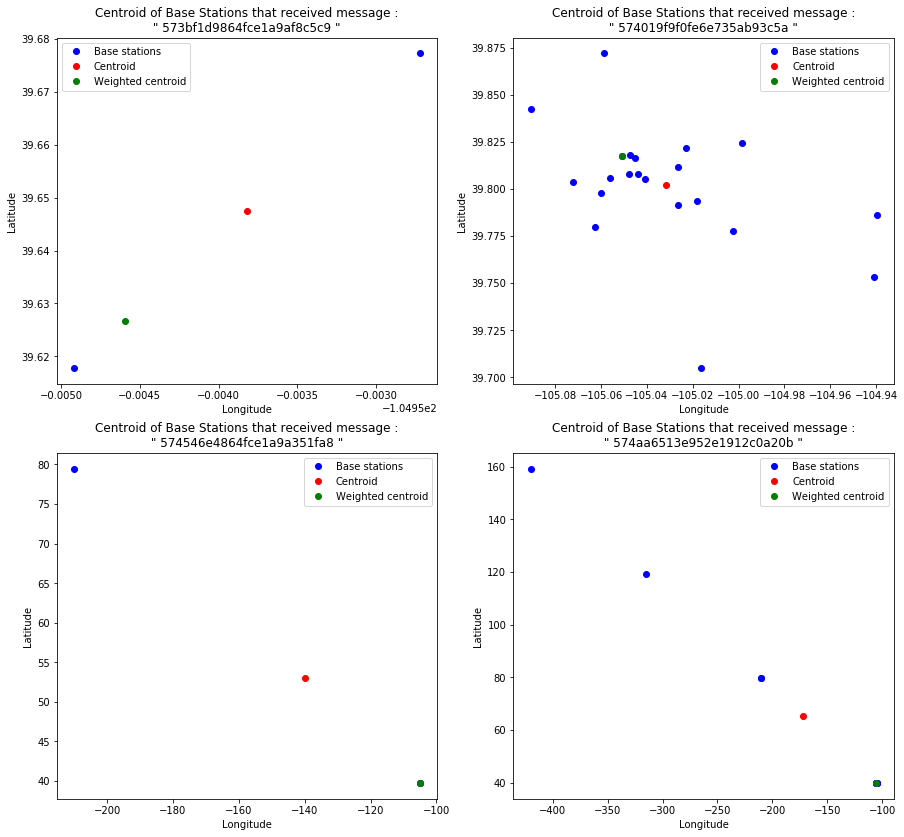

In [28]:
# Plot of the location of base stations and their centroid for a few message
plt.figure(figsize=(15,14))

for i in range(4):
    plt.subplot(221+i)
    plot_bases((i+5)*(10*i))
    plt.plot(df_weigh['lng'].iloc[(i+5)*(10*i)], df_weigh['lat'].iloc[(i+5)*(10*i)], 'og', label='Weighted centroid')
    plt.legend()
plt.show()

#### Definition of final feature matrix

Once we created the features mentionned above, we tested with cross validation the performance of different models on different combination of the features:
- all together
- all together without weighted centroid
- all together without "normal" centroid
- "normal" centroid only
- weighted centroid only

Ultimately, it appeared the combination of features that provided us with the best performance score was the last one : when using only weighted centroids of latitude and longitude.
Fortunately, this helps reduce the dimension of the feature matrix, hence the computation time when training and testing our algorithms for best model selection.

** Below is the function that builds the feature matrix we will use for the rest of the project**

In [32]:
# Final feature matrix function that only builds the features we want to keep

def feat_mat_const_centroid(df_mess_train, listOfBs):
    ''' 
    Method used for creation of features. It uses numpy for calculations due to optimization issues
    
    Parameters
    ----------
    df_mess_train: raw dataFrame with input data
    listOfBs: list of unique bases present in both train and test sets
    
    Returns
    -------
    df_feat: modified dataFrame with created features: longitude and latitude of the (weighted) 
    centroid of the bases that detected each message
    '''
    
    bases_num = len(listOfBs)
    
    # One-hot encoding of the data : from rows to columns
    
    # Dictionnary that will track the column in the numpy array and its correpondent base 
    bases_dict = {}
    for i, column in enumerate(listOfBs):
        bases_dict[column] = i
    
    
    # Creating array to be transformed at feature matrix (columns = features)
    lat_array = np.zeros((df_mess_train.shape[0], bases_num))
    lng_array = np.zeros((df_mess_train.shape[0], bases_num))
    weights_array = np.zeros((df_mess_train.shape[0], bases_num))
    
    # assigning values for new features
    for i in df_mess_train.index:
        # getting bsid for current row
        bsid = df_mess_train.loc[i, 'bsid']
        # getting colum to assign value in bases_array
        column = bases_dict[bsid]
        # assigning weight (sqrt(rssi)) value to cell in bases array
        weight = np.exp(df_mess_train.loc[i, 'rssi'])**(1/2)
        lat_array[i, column] = weight * df_mess_train.loc[i, 'bs_lat']
        lng_array[i, column] = weight * df_mess_train.loc[i, 'bs_lng']
        weights_array[i, column] = weight
    
    # Tranforming bases_array to dataFrame in order to use .groupby()

    lat_df = pd.DataFrame(lat_array)
    lng_df = pd.DataFrame(lng_array)
    weights_df = pd.DataFrame(weights_array)
    
    
    # Using groupby() and getting final dataFrame of features
    
    # Adding messid column to each data-frame (lat, lng and weights)
    lat_df['messid'] = df_mess_train['messid']
    lng_df['messid'] = df_mess_train['messid']
    weights_df['messid'] = df_mess_train['messid']
    
    lat = lat_df.groupby('messid').sum().sum(axis=1)
    lng = lng_df.groupby('messid').sum().sum(axis=1)
    weights = weights_df.groupby('messid').sum().sum(axis=1)
    
    # Normalizing
    df_feat = pd.DataFrame([lat, lng], index=['lat','lng'])
    df_feat = (df_feat/weights).T
    
    return df_feat

## Outliers processing I [André]

## Model [Mathieu / Matyas / André]

### First raw predictions

### Outliers processing II

### Fine-tunning / Model selection

### Blending

## Test analysis [André] 